## Web Scraping Goodreads Quotes

In [1]:
# Importing in each cell because of the kernel restarts.
import scrapy
import re
from scrapy.crawler import CrawlerProcess

class ESSpider(scrapy.Spider):
    # Naming the spider is important if you are running more than one spider of
    # this class simultaneously.
    name = "ESS"
    
    # URL(s) to start with.
    start_urls = [
        'https://www.goodreads.com/quotes',
    ]

    # Use XPath to parse the response we get.
    def parse(self, response):
        
        # Iterate over every element on the page.
        for div in response.xpath('//div[@class="quote"]'):
            
            # Yield a dictionary with the values we want.
            yield {
                'quote': div.xpath('div/div[1]/text()').extract(),
                'author': div.xpath('div/div[1]/span/text()').extract(),
                'likes': div.xpath('div/div[2]/div[2]/a/text()').extract(),
            }
        # Get the URL of the previous page.
        next_page = response.xpath('//div[@style="text-align: right; width: 100%"]/div/a/@href').extract_first()
        
        pagenum = int(re.findall(r'\d+',next_page)[0])
        # Recursively call the spider to run on the next page, if it exists.
        if next_page is not None and pagenum < 25:
            next_page = response.urljoin(next_page)
            # Request the next page and recursively parse it the same way we did above
            yield scrapy.Request(next_page, callback=self.parse)

# Tell the script how to run the crawler by passing in settings.
# The new settings have to do with scraping etiquette.          
process = CrawlerProcess({
    'FEED_FORMAT': 'json',         # Store data in JSON format.
    'FEED_URI': 'data.json',       # Name our storage file.
    'LOG_ENABLED': False,          # Turn off logging for now.
    'ROBOTSTXT_OBEY': True,
    'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True
})

# Start the crawler with our spider.
process.crawl(ESSpider)
process.start()
print('Success!')

Success!


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [3]:
quotes=pd.read_json('data.json', orient='records')
quotes.head()

,author,likes,quote
0,[\n Marilyn Monroe\n ],[149316 likes],"[\n “I'm selfish, impatient and a little ..."
1,[\n Oscar Wilde\n ],[147356 likes],[\n “Be yourself; everyone else is alread...
2,[\n Albert Einstein\n ],[130706 likes],[\n “Two things are infinite: the univers...
3,[\n Frank Zappa\n ],[126341 likes],"[\n “So many books, so little time.”\n ,..."
4,[\n Bernard M. Baruch\n ],[120238 likes],[\n “Be who you are and say what you feel...


In [4]:
quotes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 3 columns):
author    90 non-null object
likes     90 non-null object
quote     90 non-null object
dtypes: object(3)
memory usage: 2.2+ KB


## Data Cleaning

In [5]:
# Remove '[]' from dataframe
quotes['likes'] = quotes['likes'].str.get(0)
quotes['author'] = quotes['author'].str.get(0)
quotes['quote'] = quotes['quote'].str.get(0)

In [6]:
# Remove all \n from dataframe
quotes = quotes.replace('\n', '', regex=True)

# Remove ',' from author column
quotes['author'] = quotes['author'].replace(',', '', regex=True)

In [7]:
# Get rid of 'likes' in likes column
quotes['likes'] = quotes['likes'].str.replace("likes", "")

# Make likes column numeric
quotes['likes'] = pd.to_numeric(quotes['likes'])

In [8]:
# Create new column word counts
quotes['word_counts'] = quotes['quote'].apply(lambda x: len(x.split()))
quotes.head()

,author,likes,quote,word_counts
0,Marilyn Monroe,149316.0,"“I'm selfish, impatient and a little ins...",41
1,Oscar Wilde,147356.0,“Be yourself; everyone else is already t...,7
2,Albert Einstein,130706.0,“Two things are infinite: the universe a...,16
3,Frank Zappa,126341.0,"“So many books, so little time.”",6
4,Bernard M. Baruch,120238.0,"“Be who you are and say what you feel, b...",21


## Data Exploration

In [9]:
quotes['author'].value_counts().nlargest(10)

    Oscar Wilde              9
    Marilyn Monroe           5
    J.K. Rowling             5
    Mark Twain               5
    Mahatma Gandhi           4
    Albert Einstein          4
    Eleanor Roosevelt        3
    Dr. Seuss                3
    Friedrich Nietzsche      3
    Bernard M. Baruch        2
Name: author, dtype: int64

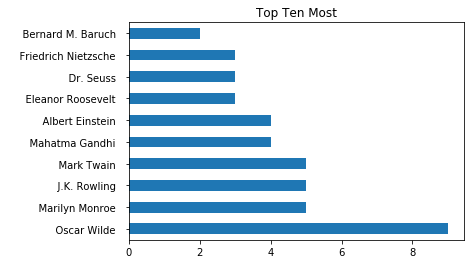

In [10]:
quotes['author'].value_counts().nlargest(10).plot.barh(title = "Top Ten Most")

Average number of likes: 74270.91860465116


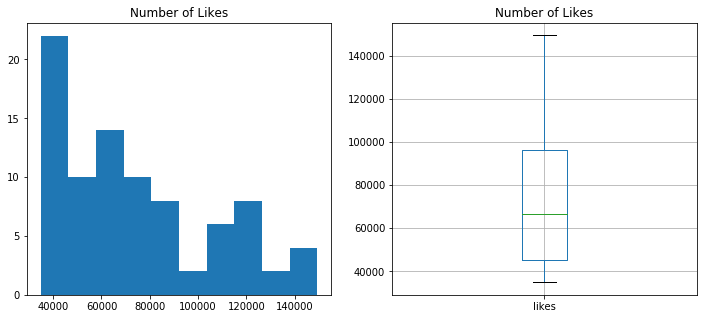

In [11]:
print("Average number of likes:", quotes['likes'].mean())

plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.hist(quotes['likes'])
plt.title("Number of Likes")

plt.subplot(1,2,2)
quotes.boxplot(column = ['likes'])
plt.title("Number of Likes")

plt.show()

Average words per quote: 24.644444444444446


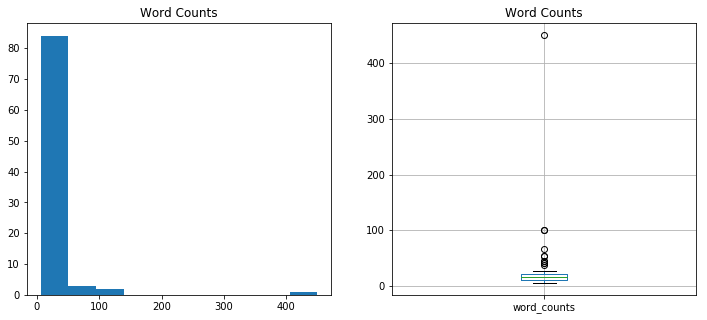

In [12]:
print("Average words per quote:", quotes['word_counts'].mean())

plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.hist(quotes['word_counts'])
plt.title("Word Counts")

plt.subplot(1,2,2)
quotes.boxplot(column = ['word_counts'])
plt.title("Word Counts")

plt.show()

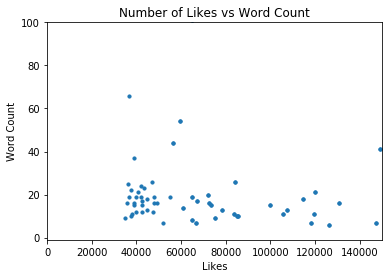

In [13]:
plt.scatter(quotes['likes'], quotes['word_counts'], s = 10)
plt.xlim(0, 150000)
plt.ylim(-1, 100)
plt.xlabel("Likes")
plt.ylabel("Word Count")
plt.title("Number of Likes vs Word Count")

plt.show()